In [3]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from skimage.feature import hog
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

Elaborazione: 100%|██████████| 8492/8492 [00:32<00:00, 259.37it/s]


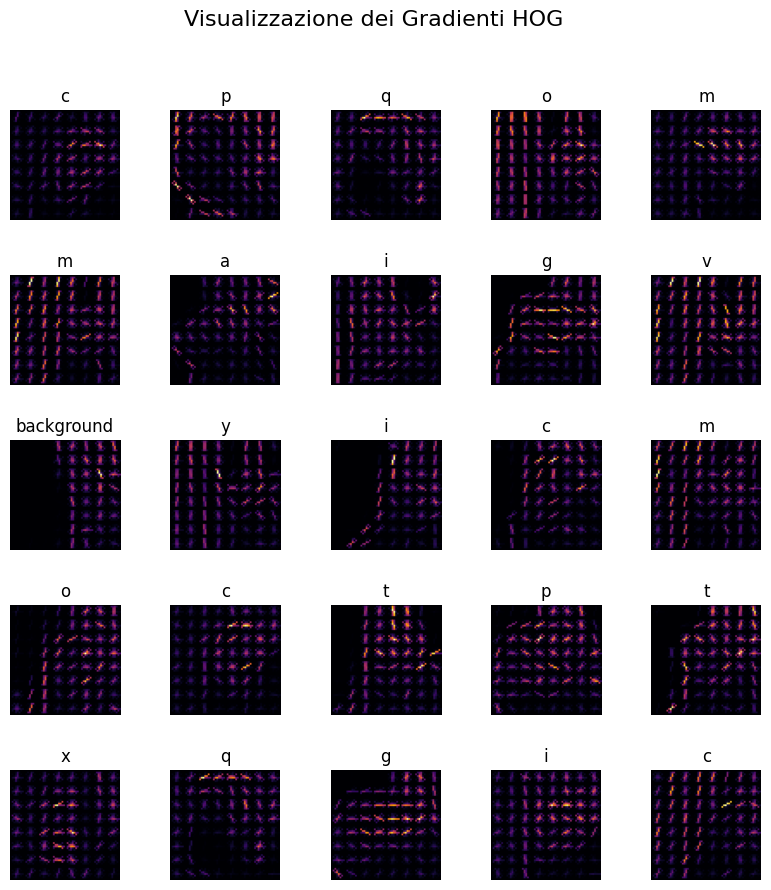

In [4]:
def load_with_hog_viz(folder_path, img_size=64, n_to_show=25):
    features_list = []
    labels_list = []
    hog_images = [] # Qui salviamo le immagini HOG da plottare

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    all_files = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
    
    for i, filename in enumerate(tqdm(all_files, desc="Elaborazione")):
        label = filename.split('_')[0]
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None: continue
            
        img_res = cv2.resize(img, (img_size, img_size))
        img_eq = clahe.apply(img_res)
        
        # Estrazione HOG con visualizzazione
        # fd è il vettore delle feature (1764 elementi)
        # hog_image è l'immagine 64x64 dei gradienti
        fd, hog_image = hog(img_eq, orientations=9, pixels_per_cell=(8, 8),
                            cells_per_block=(2, 2), visualize=True)
        
        features_list.append(fd)
        labels_list.append(label)
        
        if i < n_to_show:
            hog_images.append(hog_image)
        
    return np.array(features_list), np.array(labels_list), hog_images

# Carichiamo i dati
X, y, imgs_hog = load_with_hog_viz("/home/mattia/Desktop/unige/ml2/machineLearning2_Assignment/training-a-robot-to-understand-sign-language/signlanguage/signlanguage")

Xl, Xt, yl, yt = train_test_split(X, y, test_size=0.75, random_state=11)

# --- PLOT DELL'HOG ---
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(10,10))
for i, ax in enumerate(axs.reshape(-1)):
    # L'immagine HOG è già 64x64, non serve reshape
    ax.imshow(imgs_hog[i], cmap='inferno') # 'inferno' o 'gray' rendono bene l'idea dei gradienti
    ax.axis('off')
    ax.set_title(str(y[i]))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("Visualizzazione dei Gradienti HOG", fontsize=16)
plt.show()

In [5]:
from sklearn.svm import LinearSVC

# Griglia per LinearSVC (usa 'C' come SVC, ma è molto più rapido)
grid = {'C': np.logspace(-6, 3, 10)}

M = GridSearchCV(estimator  = LinearSVC(dual=False), # dual=False è meglio quando n_samples > n_features
                 param_grid = grid,
                 cv         = 10,
                 scoring    = 'balanced_accuracy',
                 n_jobs     = 20)

M.fit(Xl, yl)

# Ora coef_ sarà (25, 4096)
best_model = M.best_estimator_
weights = best_model.coef_ 
print(f"Forma dei coefficienti: {weights.shape}") # Output atteso: (25, 4096)

Forma dei coefficienti: (25, 1764)


In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.tree import plot_tree

def quality(M,XT,YT):
  Yp = M.predict(XT)
  print('ACC: ' + format(accuracy_score(YT,Yp),".3f"))
  print('BAC: ' + format(balanced_accuracy_score(YT,Yp),".3f"))
  print('CM: \n' + str(confusion_matrix(YT,Yp)))
quality(M,Xt,yt)

ACC: 0.958
BAC: 0.961
CM: 
[[266   1   3   0   1   0   0   0   0   0   2   0   0   0   0   0   0   2
    0   0   0   0   0   0   2]
 [  0 356   3   0   0   1   4   0   0   0   0   0   0   0   0   0   0   0
    2   4   0   0   0   0   0]
 [  0   0 355   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0]
 [  0   0   0 277   0   0   0   0   0   0   0   0   0   1   1   0   0   0
    0   0   0   0   0   0   0]
 [  1   4   0   0 196   1   1   0   0   1   5   0   5   0   0   0   0   0
    0   0   0   0   0   1   0]
 [  1   0   0   0   1 194   0   0   0   0   0   0   1   1   0   0   0   0
    0   0   0   0   0   0   0]
 [  1   1   1   0   0   0 239   0   0   1   0   0   0   0   0   0   0   1
    0   0   0   0   0   0   2]
 [  0   0   0   0   0   0   0 214   2   0   0   0   2   0   0   0   0   0
    0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   3 270   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   2   0]
 [  0   0   0   0   2   0   

Classe a: Sparsity = 0.79%
Classe b: Sparsity = 0.40%
Classe background: Sparsity = 1.42%
Classe c: Sparsity = 0.74%
Classe d: Sparsity = 0.96%
Classe e: Sparsity = 1.02%
Classe f: Sparsity = 0.74%
Classe g: Sparsity = 1.47%
Classe h: Sparsity = 1.47%
Classe i: Sparsity = 0.85%
Classe k: Sparsity = 0.62%
Classe l: Sparsity = 2.15%
Classe m: Sparsity = 0.34%
Classe n: Sparsity = 0.40%
Classe o: Sparsity = 0.85%
Classe p: Sparsity = 1.53%
Classe q: Sparsity = 2.61%
Classe r: Sparsity = 1.08%
Classe s: Sparsity = 1.25%
Classe t: Sparsity = 0.96%
Classe u: Sparsity = 0.74%
Classe v: Sparsity = 0.74%
Classe w: Sparsity = 0.68%
Classe x: Sparsity = 0.79%
Classe y: Sparsity = 0.74%


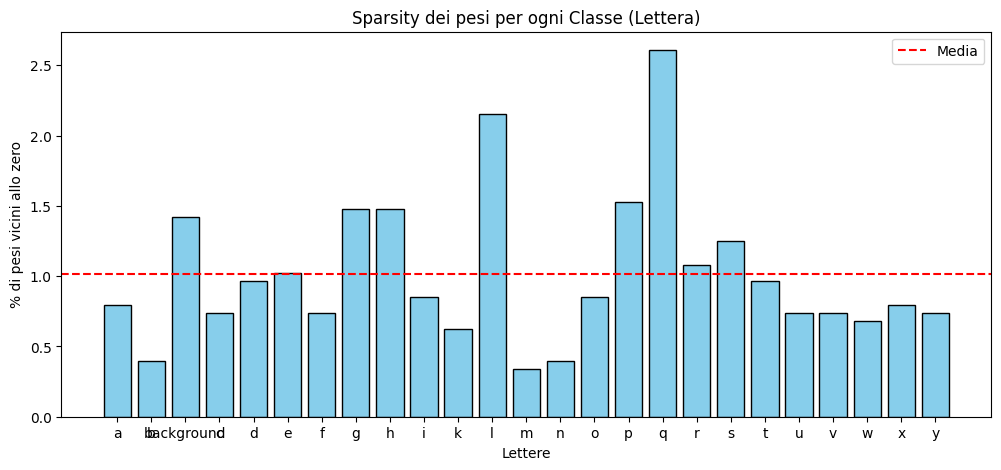

In [12]:
# Soglia di tolleranza: i pesi più piccoli di questa sono considerati "sparsi"
threshold = 1e-3

# Per ogni classe (riga di w), calcoliamo la % di elementi sotto soglia
for i, class_name in enumerate(w_best.classes_):
    n_zero = np.sum(np.abs(w[i]) < threshold)
    sparsity = (n_zero / w.shape[1]) * 100
    print(f"Classe {class_name}: Sparsity = {sparsity:.2f}%")

sparsity_list = [np.mean(np.abs(w[i]) < threshold) * 100 for i in range(len(w))]

plt.figure(figsize=(12, 5))
plt.bar(w_best.classes_, sparsity_list, color='skyblue', edgecolor='black')
plt.axhline(y=np.mean(sparsity_list), color='r', linestyle='--', label='Media')

plt.title("Sparsity dei pesi per ogni Classe (Lettera)")
plt.ylabel("% di pesi vicini allo zero")
plt.xlabel("Lettere")
plt.legend()
plt.show()

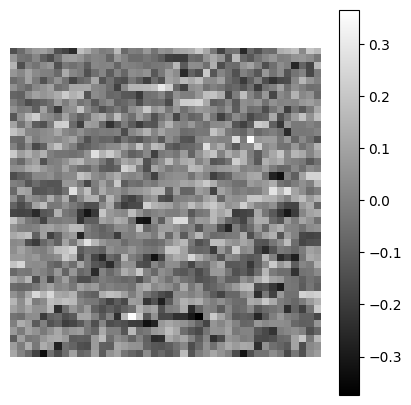

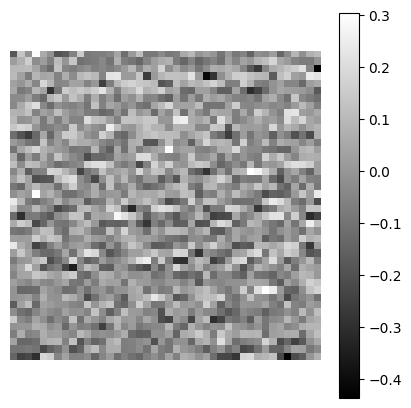

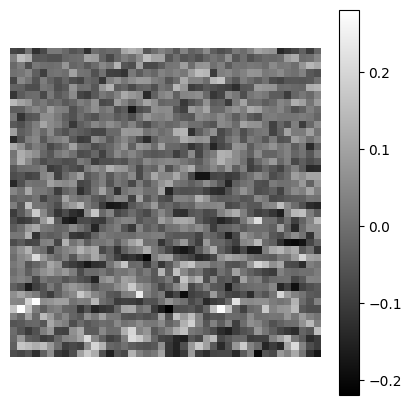

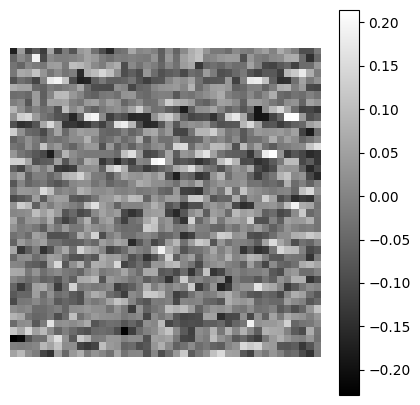

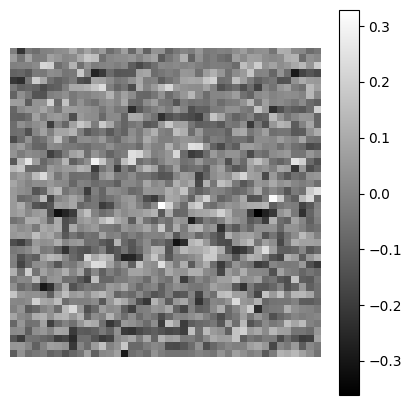

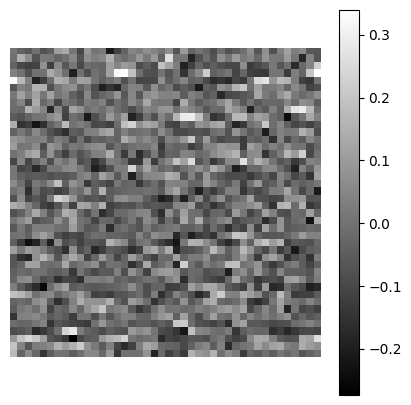

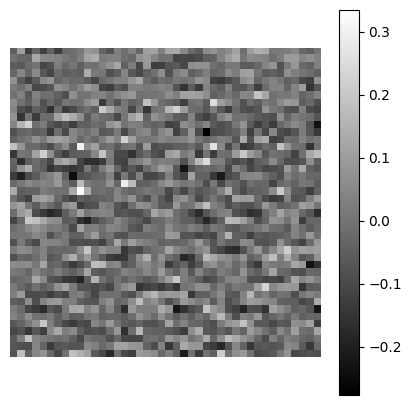

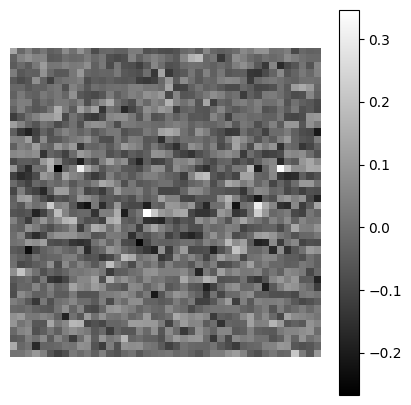

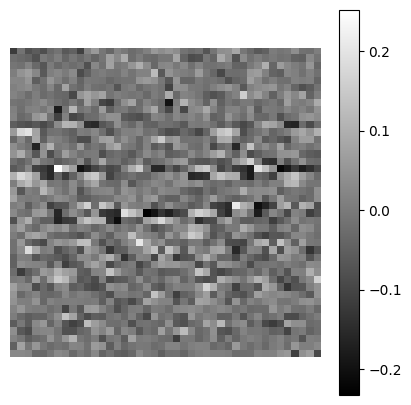

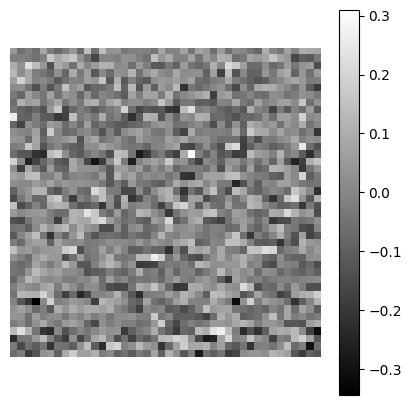

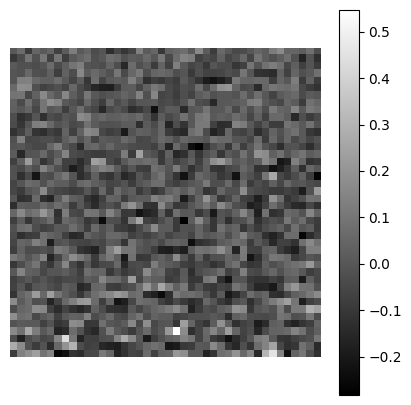

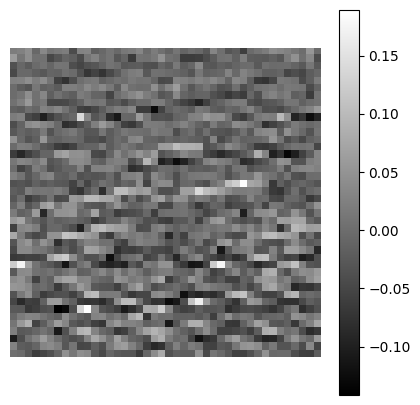

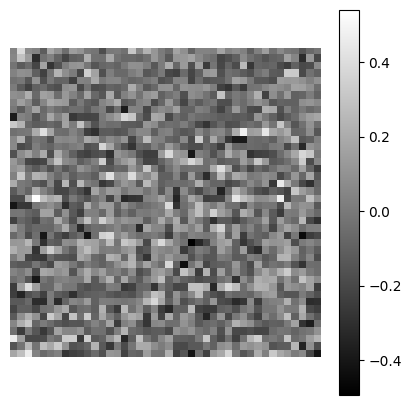

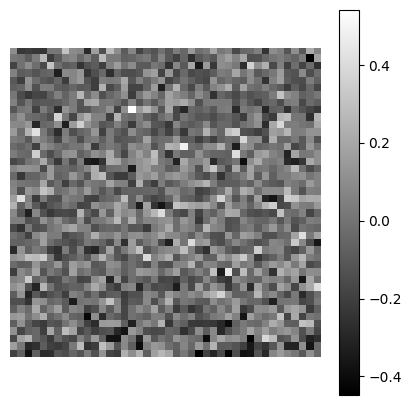

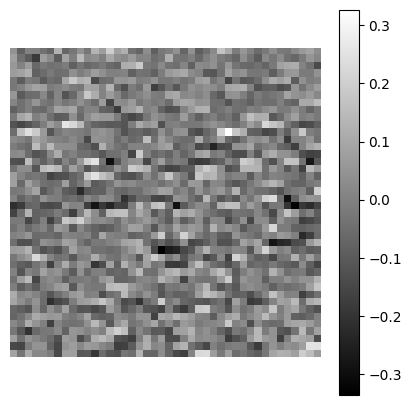

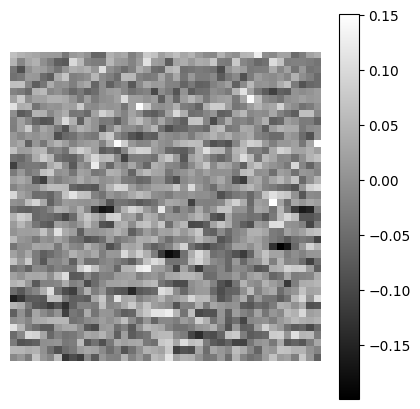

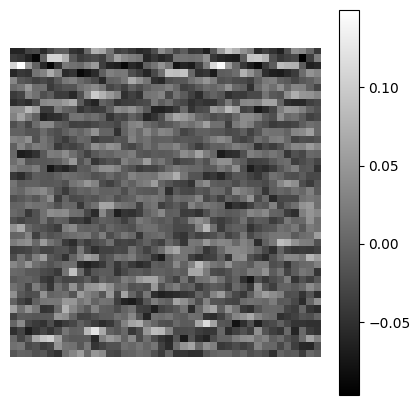

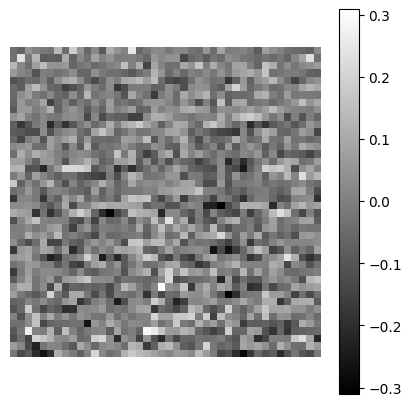

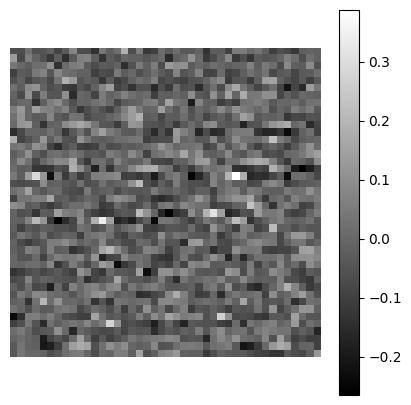

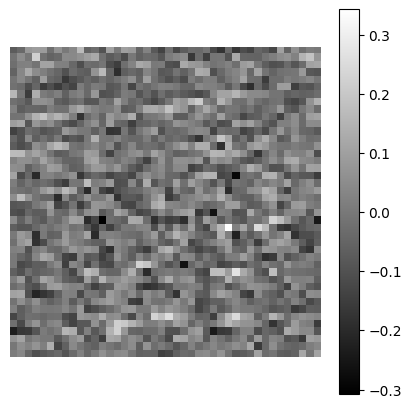

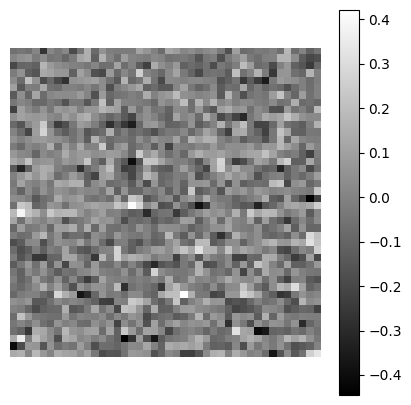

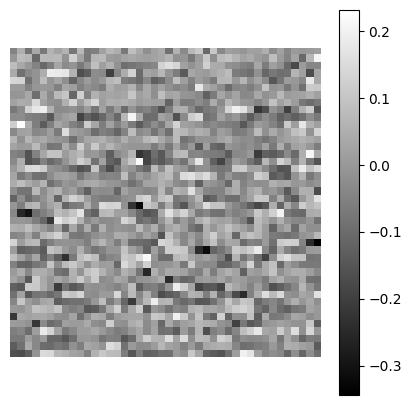

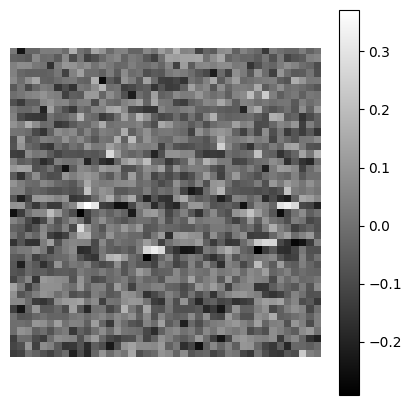

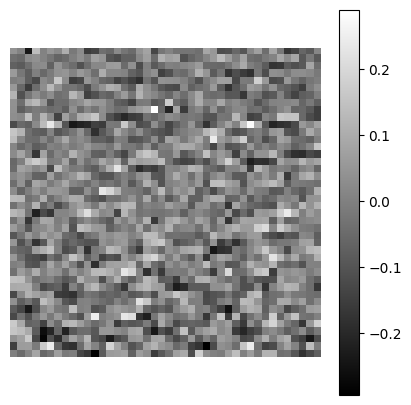

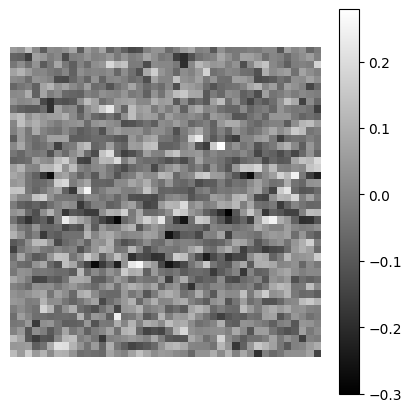

In [7]:
import matplotlib.pyplot as plt

w_best = M.best_estimator_
w = w_best.coef_
for i in range(len(w)):
    model = np.reshape(w[i],(42,42))
    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(model, cmap='gray')
    ax.axis('off')
    fig.colorbar(im)
    plt.show()